In [1]:
import numpy as np
import scipy.misc
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import scipy.misc
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
cascPath = "haarcascade_frontalface_default.xml"
# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)


In [89]:
## read the dataset
full_face = []
full_labels = []
all_images = os.listdir('yalefaces')
for j in range(1,16):    # there are 15 different people in the dataset
    img_list = [filename for filename in all_images if filename.startswith('subject%.2d'%j)]
#     img_list = glob.glob('yalefaces/subject%.2d*'%j)
    face1 = np.zeros((len(img_list),64,64))
    for k,img in enumerate(img_list):
        I = scipy.misc.imread(os.path.join('yalefaces',img))
        #print(type(I))
        I = cv2.fastNlMeansDenoising(I, None, 9, 13)
        I = cv2.GaussianBlur(I, (5,5), 0)
        I = cv2.equalizeHist(I)
        faces = faceCascade.detectMultiScale(
            I,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30))
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
        
    labels = (j-1)*np.ones((11,))
    full_face.append(face1)
    full_labels.append(labels)
full_face = np.stack(full_face)    # contains the images of all faces
full_labels = np.stack(full_labels)   # contains the ID of all the faces
full_face = np.stack(full_face)    # contains the images of all faces
full_labels = np.stack(full_labels)   # contains the ID of all the faces

In [90]:
print(full_face.shape)
full_labels.shape

(15, 11, 64, 64)


(15, 11)

In [91]:
full_face = full_face/255.0 #normalise data

In [92]:
# divide the data into train and test
# pick 2 images from each dataset and put it into test set
train_set = np.zeros((full_face.shape[0],9,64,64))
test_set = np.zeros((full_face.shape[0],2,64,64))
train_labels = np.zeros((full_face.shape[0],9))
test_labels = np.zeros((full_face.shape[0],2))
for k in range(full_face.shape[0]):
    g = np.random.permutation(10)   # randomly select the 9 faces
    train_set[k,...] = full_face[k,g[:9],...]
    train_labels[k,...] = full_labels[k,g[:9]]
    test_set = full_face[:,g[9:],...]
    test_labels[k,...] = full_labels[k,g[9:]]

In [93]:
from skimage.feature import local_binary_pattern
train_set = np.reshape(train_set,[-1,64,64])
train_labels = np.reshape(train_labels,[-1,])
test_set = np.reshape(test_set,[-1,64,64])
test_labels = np.reshape(test_labels,[-1,])
train_feat = np.zeros_like(train_set)
test_feat = np.zeros_like(test_set)

for k in range(train_feat.shape[0]):
        train_feat[k,...] = local_binary_pattern(train_set[k,...],8,3)#,method='uniform')
for k in range(test_feat.shape[0]):
        test_feat[k,...] = local_binary_pattern(test_set[k,...],8,3)#,method='uniform')
print(np.amax(test_feat))

255.0


In [94]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7
grid_size_x = train_feat.shape[1]//x_grid
grid_size_y = train_feat.shape[2]//y_grid
for k in range(train_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = train_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        data_hist = patch_hist_list[np.newaxis,...]
    else:
        data_hist = np.concatenate([data_hist,patch_hist_list[np.newaxis,...]],0)
print(data_hist.shape)

grid_size_x = test_feat.shape[1]//x_grid
grid_size_y = test_feat.shape[2]//y_grid

for k in range(test_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = test_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        test_data_hist = patch_hist_list[np.newaxis,...]
    else:
        test_data_hist = np.concatenate([test_data_hist,patch_hist_list[np.newaxis,...]],0)
print(test_data_hist.shape)

(135, 3136)
(15, 3136)


In [95]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
train_feat = data_hist
test_feat = test_data_hist
print(train_feat.shape,test_feat.shape)
pca.fit(train_feat)

(135, 3136) (15, 3136)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [96]:
# select number of components which explain 99% of the data variance
n_components = np.argmin(np.cumsum(pca.explained_variance_ratio_)<=0.99)
print(n_components)
train_feat_pca = pca.transform(train_feat)
train_feat_pca = train_feat_pca[:,:n_components]
test_feat_pca = pca.transform(test_feat)
test_feat_pca = test_feat_pca[:,:n_components]
print(train_feat_pca.shape)

120
(135, 120)


In [97]:
import itertools
img_pair = []
img_full_pair = []
label_pair = []
for pair in itertools.combinations_with_replacement(range(train_feat_pca.shape[0]),2):
    img_pair.append(train_feat_pca[pair,:])
    img_full_pair.append(train_set[pair,:])
    label_pair.append(train_labels[pair,])
img_pair = np.stack(img_pair)
img_full_pair = np.stack(img_full_pair)
label_pair = np.stack(label_pair)
label_pair = (label_pair[:,0] == label_pair[:,1])
label_pair = label_pair*1
print(img_pair.shape)

(9180, 2, 120)


In [98]:
test_img_pair = []
test_label_pair = []
for pair in itertools.combinations_with_replacement(range(test_feat.shape[0]),2):
    test_img_pair.append(test_feat_pca[pair,...])
    test_label_pair.append(test_labels[pair,])
test_img_pair = np.stack(test_img_pair)
test_label_pair = np.stack(test_label_pair)
test_label_pair = (test_label_pair[:,0] == test_label_pair[:,1])
test_label_pair = test_label_pair*1

In [99]:
img_pair = np.abs(img_pair[:,0,...] - img_pair[:,1,...])
test_img_pair = np.abs(test_img_pair[:,0,...] - test_img_pair[:,1,...])
print(test_img_pair.shape)

(120, 120)


In [100]:
# shuffle the training data
g = np.random.permutation(img_pair.shape[0])
img_pair = img_pair[g,:]
label_pair = label_pair[g,]




In [101]:
img_pair.shape

(9180, 120)

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
mlp = MLPClassifier(activation='tanh',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(8,10,10,10,10,10), random_state=1)
mlp.fit(img_pair,label_pair)

MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 10, 10, 10, 10, 10),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [104]:
print('Test Accuracy : ',mlp.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',mlp.score(img_pair,label_pair))
ypred=mlp.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=mlp.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  0.9420479302832244
Test F1 :  0.8108108108108109
Train F1 :  0.3496332518337408


In [105]:
dt=DecisionTreeClassifier()
dt.fit(img_pair,label_pair)
print('Test Accuracy : ',dt.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',dt.score(img_pair,label_pair))
ypred=dt.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=dt.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  1.0
Test F1 :  0.8108108108108109
Train F1 :  1.0


In [106]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(img_pair,label_pair)
print('Test Accuracy : ',lr.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',lr.score(img_pair,label_pair))
ypred=lr.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=lr.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  0.961764705882353
Test F1 :  0.8108108108108109
Train F1 :  0.6770929162833487


In [279]:
from sklearn.svm import SVC
svm=SVC(kernel='rbf')
svm.fit(img_pair,label_pair)
print(svm.score(test_img_pair,test_label_pair))
ypred=svm.predict(test_img_pair)
print(f1_score(y_pred=ypred,y_true=test_label_pair))

0.7424242424242424
0.5641025641025641


In [107]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier()
ada.fit(img_pair,label_pair)
print('Test Accuracy : ',ada.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',ada.score(img_pair,label_pair))
ypred=ada.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=ada.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9166666666666666
Train Accuracy :  0.9564270152505446
Test F1 :  0.761904761904762
Train F1 :  0.6521739130434783


In [108]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(criterion='gini',n_estimators=20,max_features='sqrt')
rf.fit(img_pair,label_pair)
print('Test Accuracy : ',rf.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',rf.score(img_pair,label_pair))
ypred=rf.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=rf.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  0.9974945533769063
Test F1 :  0.8108108108108109
Train F1 :  0.9826676714393369


In [281]:
print(rf.score(img_pair,label_pair))

0.9983349983349983


In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(img_pair,label_pair)
print('Test Accuracy : ',knn.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',knn.score(img_pair,label_pair))
ypred=knn.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=knn.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9916666666666667
Train Accuracy :  0.9534657836644591
Test F1 :  0.967741935483871
Train F1 :  0.5697959183673469


In [109]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda=QuadraticDiscriminantAnalysis()
qda.fit(img_pair,label_pair)
print('Test Accuracy : ',qda.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',qda.score(img_pair,label_pair))
ypred=qda.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=qda.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  0.9925925925925926
Test F1 :  0.8205128205128205
Train F1 :  0.9470404984423676


In [110]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=QuadraticDiscriminantAnalysis()
lda.fit(img_pair,label_pair)
print('Test Accuracy : ',lda.score(test_img_pair,test_label_pair))
print('Train Accuracy : ',lda.score(img_pair,label_pair))
ypred=lda.predict(test_img_pair)
print('Test F1 : ',f1_score(y_pred=ypred,y_true=test_label_pair))
ypred_train=lda.predict(img_pair)
print('Train F1 : ',f1_score(y_pred=ypred_train,y_true=label_pair))

Test Accuracy :  0.9416666666666667
Train Accuracy :  0.9925925925925926
Test F1 :  0.8205128205128205
Train F1 :  0.9470404984423676


In [282]:
pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1])

## Validation

In [233]:
## read the dataset
full_val_face = []
full_val_labels = []
all_val_images = os.listdir('yalefaces')
for j in range(11,16):    # there are 15 different people in the dataset
    img_list = [filename for filename in all_val_images if filename.startswith('subject%.2d'%j)]
#     img_list = glob.glob('yalefaces/subject%.2d*'%j)
    face1 = np.zeros((len(img_list),64,64))
    for k,img in enumerate(img_list):
        I = scipy.misc.imread(os.path.join('yalefaces',img))
        #print(type(I))
        I = cv2.fastNlMeansDenoising(I, None, 9, 13)
        I = cv2.GaussianBlur(I, (5,5), 0)
        I = cv2.equalizeHist(I)
        faces = faceCascade.detectMultiScale(
            I,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30))
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
        
    labels = (j-1)*np.ones((11,))
    full_val_face.append(face1)
    full_val_labels.append(labels)
full_val_face = np.stack(full_val_face)    # contains the images of all faces
full_val_labels = np.stack(full_val_labels)   # contains the ID of all the faces
full_val_face = np.stack(full_val_face)    # contains the images of all faces
full_val_labels = np.stack(full_val_labels)   # contains the ID of all the faces

In [234]:
print(full_val_face.shape)
print(full_val_labels.shape)
full_val_face = full_val_face/255 #normalise data

(5, 11, 64, 64)
(5, 11)


In [235]:
# divide the data into train and test
# pick 2 images from each dataset and put it into test set

val_set = np.zeros((full_val_face.shape[0],11,64,64))

val_labels = np.zeros((full_face.shape[0],11))
for k in range(full_val_face.shape[0]):
    g = np.random.permutation(11)   # randomly select the 9 faces
    val_set = full_face[:,g,...]
    val_labels[k,...] = full_labels[k,g]

In [236]:
val_set = np.reshape(val_set,[-1,64,64])
val_labels = np.reshape(val_labels,[-1,])
val_feat = np.zeros_like(test_set)

for k in range(val_feat.shape[0]):
        val_feat[k,...] = local_binary_pattern(val_set[k,...],8,3)#,method='uniform')
print(np.amax(val_feat))

255.0


In [238]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7

grid_size_x = val_feat.shape[1]//x_grid
grid_size_y = val_feat.shape[2]//y_grid

for k in range(val_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = val_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=150)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        val_data_hist = patch_hist_list[np.newaxis,...]
    else:
        val_data_hist = np.concatenate([val_data_hist,patch_hist_list[np.newaxis,...]],0)
print(val_data_hist.shape)

(20, 7350)


In [239]:
val_feat_pca = pca.transform(val_data_hist)
val_feat_pca = val_feat_pca[:,:n_components]
print(val_feat_pca.shape)

(20, 80)


In [240]:
val_img_pair = []
val_label_pair = []
for pair in itertools.combinations_with_replacement(range(val_feat.shape[0]),2):
    val_img_pair.append(val_feat_pca[pair,...])
    val_label_pair.append(val_labels[pair,])
val_img_pair = np.stack(val_img_pair)
val_label_pair = np.stack(val_label_pair)
val_label_pair = (val_label_pair[:,0] == val_label_pair[:,1])
val_label_pair = val_label_pair*1

In [241]:
val_img_pair = np.abs(val_img_pair[:,0,...] - val_img_pair[:,1,...])

In [242]:
print(dt.score(val_img_pair,val_label_pair))
ypred=dt.predict(val_img_pair)
print(f1_score(y_pred=ypred,y_true=val_label_pair))

0.9523809523809523
0.9532710280373833


In [243]:
print(rf.score(val_img_pair,val_label_pair))
ypred=rf.predict(val_img_pair)
print(f1_score(y_pred=ypred,y_true=val_label_pair))

0.9
0.8965517241379309


In [244]:
print(svm.score(val_img_pair,val_label_pair))
ypred=svm.predict(val_img_pair)
print(f1_score(y_pred=ypred,y_true=val_label_pair))

0.8428571428571429
0.835820895522388


In [245]:
print(lr.score(val_img_pair,val_label_pair))
ypred=lr.predict(val_img_pair)
print(f1_score(y_pred=ypred,y_true=val_label_pair))

0.8238095238095238
0.8021390374331551


In [246]:
print(mlp.score(val_img_pair,val_label_pair))
ypred=mlp.predict(val_img_pair)
print(f1_score(y_pred=ypred,y_true=val_label_pair))

0.8238095238095238
0.8


## Testing

In [22]:
import h5py

In [23]:
h5f = h5py.File('test.h5','r')

In [24]:
h5f.keys()

KeysView(<HDF5 file "test.h5" (mode r)>)

In [64]:
a = list(h5f.keys())
len(a)

120

In [111]:
## read the dataset
full_face = []
full_labels = []
img_list=[h5f[i] for i in a]
face1 = np.zeros((len(img_list),64,64))
for k,img in enumerate(img_list):
    I = np.array(img)#scipy.misc.imread(os.path.join('yalefaces',img))
    #print(type(I))
    I = cv2.fastNlMeansDenoising(I, None, 9, 13)
    I = cv2.GaussianBlur(I, (5,5), 0)
    I = cv2.equalizeHist(I)
    faces = faceCascade.detectMultiScale(
        I,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30))
    #print(k)
    #print(faces)
    try : 
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
    except : 
        x,y,h,w=[0,0,111,91]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
    
    


In [112]:
face1=face1/255.0

In [113]:
#LBP
test_data=face1
test_data_feat = np.zeros_like(test_data)

for k in range(test_data_feat.shape[0]):
        test_data_feat[k,...] = local_binary_pattern(test_data[k,...],8,3)#,method='uniform')
print(np.amax(test_data_feat))
print(test_data_feat.shape)

255.0
(120, 64, 64)


In [114]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7

grid_size_x = test_data_feat.shape[1]//x_grid
grid_size_y = test_data_feat.shape[2]//y_grid

for k in range(test_data_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = test_data_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        test_data_hist = patch_hist_list[np.newaxis,...]
    else:
        test_data_hist = np.concatenate([test_data_hist,patch_hist_list[np.newaxis,...]],0)
print(test_data_hist.shape)

(120, 3136)


In [115]:
test_feat_pca = pca.transform(test_data_hist)
test_feat_pca = test_feat_pca[:,:n_components]
print(test_feat_pca.shape)

(120, 120)


In [116]:
test_pairs = np.genfromtxt('image_pairs.csv', dtype=None, delimiter=',', names=True)
test_pairs[0]

(0, 155, 140)

In [117]:
ids=[]
image1=[]
image2=[]
test_img_pairs=[]
for i in range(len(test_pairs)) : 
    ids.append(test_pairs[i][0])
    image1.append(test_pairs[i][1])
    image2.append(test_pairs[i][2])
    pair=(a.index(str(test_pairs[i][1])),a.index((str(test_pairs[i][2]))))
    
    test_img_pairs.append(test_feat_pca[pair,:])
test_img_pairs = np.stack(test_img_pairs)

In [118]:
test_img_pairs = np.abs(test_img_pairs[:,0,...] - test_img_pairs[:,1,...])

In [122]:
pred=ada.predict(test_img_pairs)

In [123]:
pred.shape

(3540,)

In [124]:
with open('ada_yaleA_full_9_2.csv','w') as f : 
    f.write('Id,Expected\n')
    for i in range(len(test_pairs)) : 
        
        f.write(str(ids[i])+','+str(pred[i])+'\n')

In [95]:
test_data=h5f[a[22]]
test_data=np.array(test_data)

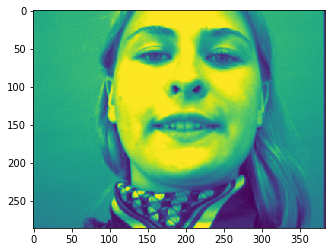

In [96]:
plt.imshow(test_data)

In [60]:
a

'100'